In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from modules.minisom import MiniSom
import tensorflow as tf

In [2]:
data = pd.read_csv("data/Credit_Card_Applications.csv")
data

,CustomerID,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,Class
0,15776156,1,22.08,11.460,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,15739548,0,22.67,7.000,2,8,4,0.165,0,0,0,0,2,160,1,0
2,15662854,0,29.58,1.750,1,4,4,1.250,0,0,0,1,2,280,1,0
3,15687688,0,21.67,11.500,1,5,3,0.000,1,1,11,1,2,0,1,1
4,15715750,1,20.17,8.170,2,6,4,1.960,1,1,14,0,2,60,159,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,15808223,1,31.57,10.500,2,14,4,6.500,1,0,0,0,2,0,1,1
686,15769980,1,20.67,0.415,2,8,4,0.125,0,0,0,0,2,0,45,0
687,15675450,0,18.83,9.540,2,6,4,0.085,1,0,0,0,2,100,1,1
688,15776494,0,27.42,14.500,2,14,8,3.085,1,1,1,0,2,120,12,1


In [3]:
X = data.drop(["Class"],axis=1)
y = data["Class"]

In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(X)
X = scaler.transform(X)

In [5]:
som = MiniSom(x=10, y=10, input_len= 15, sigma= 1.0, learning_rate = 0.5)
som.random_weights_init(X)
som.train_random(X,100)

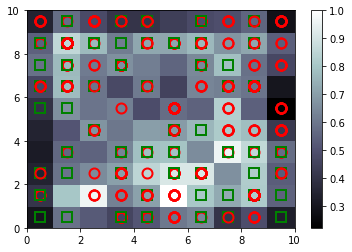

In [6]:
from pylab import bone, pcolor, colorbar, plot, show

bone()
pcolor(som.distance_map().T)
colorbar()
markers = ['o','s']
colors = ['r','g']
for i,x in enumerate(X,0):
    w = som.winner(x)
    plot(w[0]+0.5,w[1]+0.5,
         markers[y[i]],
         markeredgecolor = colors[y[i]],
         markerfacecolor="None",
         markersize=10,
         markeredgewidth=2)
show()

In [10]:
mappings = som.win_map(X)
frauds = np.concatenate((mappings[(2,1)], mappings[(5,2)]), axis = 0)
frauds = scaler.inverse_transform(frauds)

In [11]:
print('Fraud Customer IDs')
for i in frauds[:, 0]:
    print(int(i))

Fraud Customer IDs
15767264
15573798
15647295
15680643
15692137
15668830
15796569
15712877
15807546
15773869
15796111
15809800
15676909
15750055
15679801
15732943
15781975
15770255
15773789
15794868
15705506


In [12]:
customers = data.drop("CustomerID",axis=1)
is_fraud = np.zeros(len(data))
for i in range(len(data)):
    if data.iloc[i,0] in frauds:
        is_fraud[i] = 1

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)
customers = scaler.transform(customers)

In [20]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=10,input_dim=15,activation="relu"))
model.add(tf.keras.layers.Dense(units=10,activation="relu"))
model.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))
model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

r = model.fit(x=customers,y=is_fraud,epochs=10,batch_size=10)

Epoch 1/10
69/69 [==============================] - 0s 627us/step - loss: 2741.1844 - accuracy: 0.2993
Epoch 2/10
69/69 [==============================] - 0s 646us/step - loss: 1435.9460 - accuracy: 0.5365
Epoch 3/10
69/69 [==============================] - 0s 642us/step - loss: 669.2876 - accuracy: 0.6647
Epoch 4/10
69/69 [==============================] - 0s 652us/step - loss: 4.9656 - accuracy: 0.9663
Epoch 5/10
69/69 [==============================] - 0s 599us/step - loss: 5.8934 - accuracy: 0.9554
Epoch 6/10
69/69 [==============================] - 0s 659us/step - loss: 2.8740 - accuracy: 0.9366
Epoch 7/10
69/69 [==============================] - 0s 680us/step - loss: 1.8160 - accuracy: 0.9712
Epoch 8/10
69/69 [==============================] - 0s 614us/step - loss: 1.5882 - accuracy: 0.9373
Epoch 9/10
69/69 [==============================] - 0s 649us/step - loss: 1.8215 - accuracy: 0.9481
Epoch 10/10
69/69 [==============================] - 0s 604us/step - loss: 1.3914 - accuracy

In [23]:
_,accuracy = model.evaluate(customers,is_fraud)

22/22 [==============================] - 0s 682us/step - loss: 1.6046 - accuracy: 0.9667


In [24]:
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 96.67%


In [44]:
y_preds = model.predict(customers)
customer_id = pd.DataFrame(data["CustomerID"])
df = pd.DataFrame(np.concatenate((customer_id,y_preds),axis=1),columns=["CustomerID","is_fraud"])
df

,CustomerID,is_fraud
0,15776156.0,8.359125e-08
1,15739548.0,3.622445e-08
2,15662854.0,1.490756e-13
3,15687688.0,3.518881e-01
4,15715750.0,2.330855e-08
...,...,...
685,15808223.0,2.742618e-01
686,15769980.0,1.599197e-01
687,15675450.0,4.972464e-05
688,15776494.0,4.926033e-11


In [45]:
df.sort_values(by="is_fraud")

,CustomerID,is_fraud
154,15735837.0,0.000000
198,15761733.0,0.000000
641,15572361.0,0.000000
80,15704081.0,0.000000
642,15667460.0,0.000000
...,...,...
3,15687688.0,0.351888
70,15692137.0,0.351888
681,15665181.0,0.463764
553,15781574.0,0.501068
